In [1]:
import msgpack
import pandas as pd

* For each bracket...
* Find the best score at each decision point

In [2]:
import toolz
from sklearn.utils import check_random_state
import itertools

# Run the most adaptive bracket first
# That's what matters in the serial case

In [3]:
today = "2019-06-20"

def _to_str_keys(d):
    if isinstance(d, list):
        return [_to_str_keys(di) for di in d]
    if isinstance(d, dict):
        out = {}
        for k, v in d.items():
            out[_to_str_keys(k)] = _to_str_keys(v)
        return out
    if isinstance(d, bytes):
        return d.decode()
    return d
    
with open(f"out/{today}-histories-2.msgpack", "rb") as f:
    histories = msgpack.load(f)

hists = _to_str_keys(histories)

In [9]:
def shape_history(history, **kwargs):
    scores = {}
    pf_calls = {}
    
    out = []
    cumulative_pf_calls = 0
    
    start = history[0]["elapsed_wall_time"]
    for row in history:
        scores[row["model_id"]] = row["score"]
        pf_calls[row["model_id"]] = row["partial_fit_calls"]
        cumulative_pf_calls = sum(pf_calls.values())
        
        out += [{"best_score": max(scores.values()),
                 "elapsed_wall_time": row["elapsed_wall_time"] - start,
                 "cumulative_partial_fit_calls": sum(pf_calls.values()),
                 "random_state": row["random_state"],
                 **kwargs}]
    return out

In [30]:
def _get_hist(hist, seed=None, **kwargs):
    # Walk through history
    # Keep track of number of calls
    # Randomly sample rows for hist
    rng = check_random_state(seed)
    calls_info = toolz.groupby("partial_fit_calls", hist)
    calls = sorted(list(calls_info.keys()))
    pf_calls = {h["model_id"]: 0 for h in hist}
    scores = {h["model_id"]: 0 for h in hist}
    
    out = []
    for c in calls:
        idx = rng.choice(len(calls_info[c]))
        row = calls_info[c].pop(idx)
        
        scores[row["model_id"]] = row["score"]
        pf_calls[row["model_id"]] = row["partial_fit_calls"]
        cumulative_pf_calls = sum(pf_calls.values())
        
        out.append({"best_score": max(scores.values()),
                 "cumulative_partial_fit_calls": sum(pf_calls.values()),
                 "random_state": row["random_state"],
                 **kwargs})
    return out
    
    
def shape_hyperband_history(history, seed=None, **kwargs):
    """
    This is with *one* worker
    Brackets run from most to least adaptive.
    """
    scores = {}
    pf_calls = {}
    
    out = []
    cumulative_pf_calls = 0
    
    brackets = toolz.groupby("bracket", history)
    bracks = sorted(list(brackets.keys()))
    
    rng = check_random_state(seed)
    
    out = []
    for b in bracks:
        hist = brackets[b]
        out.append(_get_hist(hist, seed=rng, **kwargs))
    return out

In [31]:
import pandas as pd

histories = [
    shape_hyperband_history(hist, alg="hyperband")
    for hist in hists["hyperband"]
]

df = pd.DataFrame(sum(histories, []))
df.head(n=2)

,0,1,2,3,4,5
0,"{'best_score': 0.29257074292570745, 'cumulativ...","{'best_score': 0.3802619738026197, 'cumulative...",None,None,None,None
1,"{'best_score': 0.25507449255074494, 'cumulativ...","{'best_score': 0.4266573342665733, 'cumulative...","{'best_score': 0.5632436756324367, 'cumulative...",None,None,None


(0.5, 0.9478202179782023)

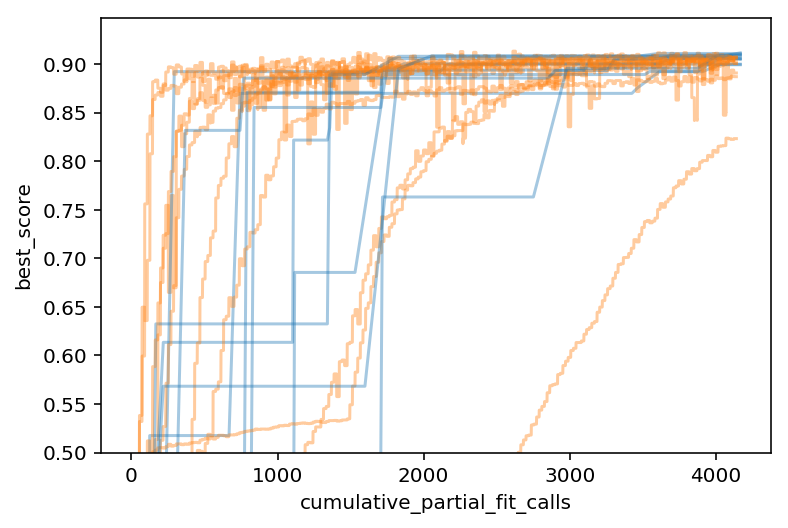

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for random_state in df.random_state.unique():
    show = df[df.random_state == random_state]
    
    ax = sns.lineplot(
        data=show,
        x="cumulative_partial_fit_calls",
        y="best_score",
        hue="alg",
        ci="sd",
        ax=ax,
        legend=False,
        alpha=0.4,
    )
ax.set_ylim(0.5, None)